# _Comic Strip Comments Analysis_
_Author: Zeth De Luna &mdash; November 9, 2020_

[WEBTOON](https://www.webtoons.com/en/) is a popular platform for creators and storytellers to publish their original content for the world to see, for free! The website is home to thousands of creator-owned content with amazing, diverse visions from all over the world.

In particular, I have chosen to analyze one of my favorite series available on WEBTOON, [_My Giant Nerd Boyfriend_](https://www.webtoons.com/en/slice-of-life/my-giant-nerd-boyfriend/list?title_no=958), the artist of which goes by the name "fishball". In this project, I'll be performing a sentiment anaylsis on fishball's very first episode, based on all the comments posted by users who have read it.

In [49]:
import pandas as pd
import datetime as dt
import re
import numpy as np
import functools
import operator
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from emoji import get_emoji_regexp
from emoji.unicode_codes import UNICODE_EMOJI
from collections import Counter

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
comments = pd.read_csv('tall_boyfriend_comments.csv')

In [3]:
comments.head()

,Unnamed: 0,comment,date
0,0,"199 cm is like 6'6"" btw for the Americans who ...","Mar 5, 2017"
1,1,My God when I got a notification saying #relat...,"Mar 5, 2017"
2,2,CONGRATULATIONS ON GETTING FEATURED!!! I remem...,"Mar 5, 2017"
3,3,im excited to see were this goes,25 mins ago
4,4,funny,1 hours ago


In [4]:
# drop 'Unnamed: 0'
comments.drop(['Unnamed: 0'], axis=1, inplace=True)

## Cleaning the Dates
The data was collected on November 6, 2020. Recent posts may have dates given in reference to the current date (date of collection), rather than an actual date. To make the dates more consistent, those date values should be corrected.

In [5]:
comments[comments['date'].str.contains('ago')]

,comment,date
3,im excited to see were this goes,25 mins ago
4,funny,1 hours ago
5,i been around tall pepole my whole life! there...,2 days ago
6,Your boyfriends a centimeters shorter than my ...,4 days ago
7,this book is weird so much,4 days ago
8,"I'm 5'1.. how does it feel, to be TALLL!?",4 days ago
9,and here a legend was born,6 days ago
21,im excited to see were this goes,25 mins ago
22,funny,1 hours ago
23,i been around tall pepole my whole life! there...,2 days ago


Since there are a small amount of dates to correct, we could just clean these up manually as such:
* date values that are listed as "mins ago" or "hours ago" indicate that the comment was posted on November 6, 2020
* we'll have to calculate and replace the dates that are listed as "days ago" manually (for example, a comment posted 2 days ago should have the date "Nov 4, 2020")

In [6]:
# replace dates with "hours" and "mins" with 'Nov 6, 2020'
comments.loc[comments['date'].str.contains('mins|hours'), 'date'] = 'Nov 6, 2020'

# if the comment was posted 2 days ago, replace with 'Nov 4, 2020'
comments.loc[comments['date']=='2 days ago', 'date'] = 'Nov 4, 2020'

# if the comment was posted 4 days ago, replace with 'Nov 2, 2020'
comments.loc[comments['date']=='4 days ago', 'date'] = 'Nov 2, 2020'

# if the comment was posted 6 days ago, replace with 'Oct 31, 2020'
comments.loc[comments['date']=='6 days ago', 'date'] = 'Oct 31, 2020'

#### Check for missing dates
When I scraped the data from the website, I filled missing values with a dash `-`.

In [7]:
# check for date values that are '-'
comments[comments['date']=='-']

,comment,date
70,-,-
285,-,-
293,-,-
576,-,-
609,-,-
624,-,-
831,-,-
856,-,-
1300,-,-
1412,-,-


It looks like "comments" with missing dates are actually missing the comments themselves. Since we've got them both here already, let's just drop these rows entirely.

In [8]:
comments = comments[~(comments['date']=='-')]

Now, to make these dates usable for analysis we'll need to convert them to datetime format.

In [9]:
# convert dates to datetime format
comments['date'] = pd.to_datetime(comments['date'], format='%b %d, %Y')

In [10]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466 entries, 0 to 1475
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   comment  1466 non-null   object        
 1   date     1466 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 34.4+ KB


## Removing Duplicates
After I created my web scraping program, I realized that what I wrote might have led to some pages being scraped twice. While I could have fixed the mistake and scraped the comments again, at the time I thought it would be faster just to clean up the mess before my analysis. Long story short, I have to check for duplicates and remove them if there are any.

In [11]:
# create a new column in the dataframe marking 'True' if the row is a duplicate
comments['duplicate'] = comments.duplicated(subset='comment', keep='first')

In [12]:
comments[comments['duplicate']==True].shape

(159, 3)

_(Wow, I should fix that web scraping error&mdash;there are 159 duplicate comments...)_

In [13]:
# keep the comments that are not duplicates (marked as False in the 'duplicate' column)
comments = comments[comments['duplicate']==False]

# we won't need the 'duplicate' column anymore
comments.drop(['duplicate'], axis=1, inplace=True)

# reset the indices
comments.reset_index(drop=True, inplace=True)

## Text Preprocessing
Let's observe some random comments to determine how we should go about doing text preprocessing.

In [14]:
for comment in comments[24:34]['comment']:
    print(comment)
    print('-'*24)

happy 500
------------------------
DAMN BOI HE THICCCQUE
------------------------
it's funny cuz, I was just watching some recommendations and THIS appears, I'm already 1,58 and my boyfriend 1,92, what kind of indirect is this? subscribing xd
------------------------
I can't stop thinking about this webtoon.They have the same inconveniences that I have with my girlfriend.
------------------------
I have a girlfriend who is Doctor, and she has 152 cm (4'9")She is little by the general height in my country Venezuela.I'm actually not very tall, I have 183 cm (6').
------------------------
i feel like m talll too😂😂having 158.5cms😂😂😂 here in NE and as a tribal girl 😂😂 but when I go outside I still cry for height🤭...I love heights🤧
------------------------
wow the development as an artist by her damn
------------------------
your short your 5,2
------------------------
my dad is 6'3 and my mom is shorter than me and im ten
------------------------
Meanwhile my brother's friend is 7,1 😂
-----

From the above comments, we see a number of things:
* There are some misspelled/lengthened words.
* There are emojis, which we might be able to use to see if the readers thought the episode was funny.
* We can remove most punctuation marks, but we'll need to keep apostrophes and quotations since many readers are posting their heights or someone else's height.
* We can make all words lowercase to make filtering a little bit easier.

Let's practice on a test comment, and then create a function containing all the steps for preprocessing.

In [15]:
test_comment = "Sooooo funmy!! I'm literallllly 5'2, and all my friends are over 6' 😂😂... THATS MY LIFE 😭 crying"

### Punctuation Removal
Again, we'll have to be careful not to remove apostrophes and quotations, since commenters used them to represent heights in feet and inches. All other punctuation marks can be removed.

In [16]:
# remove some punctuation marks
test_comment = re.sub('[,.?!#()]', '', test_comment)
test_comment

"Sooooo funmy I'm literallllly 5'2 and all my friends are over 6' 😂😂 THATS MY LIFE 😭 crying"

### Correcting Spelling
We'll need to reduce lengthened words and correct misspelled words.

In [17]:
# convert words to lowercase
test_comment = test_comment.lower()

# split the string
split_emoji = get_emoji_regexp().split(test_comment) # splits emojis from text
split_whitespace = [substr.split() for substr in split_emoji] # splits strings by whitespace (creates lists within a list)
words = functools.reduce(operator.concat, split_whitespace) # reduces multiple string lists to one
words = list(set(words)) # remove duplicate words
words

["6'",
 '😂',
 "i'm",
 'crying',
 'funmy',
 'sooooo',
 'all',
 'friends',
 'are',
 '😭',
 'my',
 'life',
 "5'2",
 'literallllly',
 'thats',
 'and',
 'over']

In [18]:
# reduce lengthened words
for index, word in enumerate(words):
    pattern = re.compile(r'(.)\1{2,}') # matches character that is repeated at least 2 times
    words[index] = pattern.sub(r'\1\1', word) # replaces repeated character with the character twice
words

["6'",
 '😂',
 "i'm",
 'crying',
 'funmy',
 'soo',
 'all',
 'friends',
 'are',
 '😭',
 'my',
 'life',
 "5'2",
 'literally',
 'thats',
 'and',
 'over']

(Notice the shortened words "soo" and "literally", the former of which we'll deal with next)

In [19]:
# correct spelling errors using TextBlob
for index, word in enumerate(words):
    w = TextBlob(word) 
    words[index] = (str(w.correct()))
words

["6'",
 '😂',
 "i'm",
 'crying',
 'funny',
 'so',
 'all',
 'friends',
 'are',
 '😭',
 'my',
 'life',
 "5'2",
 'literally',
 'that',
 'and',
 'over']

("soo" and "funmy" were corrected to "so" and "funny")

### Reading Emojis
Emojis can play an important role in text and sentiment analysis as they can often show how a person feels about a show, story, product, etc. For example, if a reader commented the "😀" emoji, which in word format is "Happy_face_smiley", we can infer that the reader reacted positively to the story. I'll be using the [emoji](https://pypi.org/project/emoji/) Python package to convert the emojis to their unicode text format.

In [20]:
# convert emojis to text
for index, word in enumerate(words):
    if word in UNICODE_EMOJI:
        emoji_code = (UNICODE_EMOJI[word]
                          .replace(':', '')
                          .split('_')
                     )
        for w in emoji_code:
            words.append(w)

# remove emojis
for word in words:
    if word in UNICODE_EMOJI:
        words.remove(word)

# remove duplicates
words = list(set(words))
words

["6'",
 "i'm",
 'friends',
 'that',
 'and',
 'are',
 'life',
 'so',
 'with',
 'over',
 'crying',
 'loudly',
 'joy',
 'funny',
 'my',
 "5'2",
 'all',
 'of',
 'face',
 'tears',
 'literally']

### Stopword Removal
Stopwords are words that may not carry any valuable information&mdash;like articles (the, it, etc.), conjunctions (and, or), or propositions (with). These types of words are more likely to appear in each comment, which wouldn't give us any indication towards how the readers feel about the episode. Python's [Natural Language Toolkit](https://www.nltk.org) has a list of about 200 stopwords, but I'll be using a custom stopwords list available __HERE__. We can also assume that many emoji unicodes will include the word "face", so we can remove that word as well.

In [21]:
# initiate stopwords
stop_words = []
with open('my_stopwords.txt', 'r') as file:
    for line in file:
        stop_words.extend(line.split())
stop_words.append('face')

# filter out the words that are in stop_words
cleaned_words = []
for word in words:
    if word not in stop_words:
        cleaned_words.append(word)
cleaned_words

["6'",
 'friends',
 'life',
 'crying',
 'loudly',
 'joy',
 'funny',
 "5'2",
 'tears',
 'literally']

### Lemmatization
Lemmatization refers to the process of reducing a word to its root. For example: _jumping, jumped,_ and _jumper_ after lemmatization would all be reduced to _jump_. This is useful for text analysis because it prevents treating different forms of the same word as different words. To do this, we can use the lemmatizer tool from the [Natural Language Toolkit](https://www.nltk.org/).

In [22]:
# initiate lemmatizer
lemmatizer = WordNetLemmatizer()

# lemmatize words in the test comment
for index, word in enumerate(cleaned_words):
    cleaned_words[index] = lemmatizer.lemmatize(word)
cleaned_words

["6'",
 'friend',
 'life',
 'cry',
 'loudly',
 'joy',
 'funny',
 "5'2",
 'tear',
 'literally']

(Notice how "crying" was shortened to "cry")

### Putting It All Together
Now that we've established the process for cleaning a comment, we can put it all together into a single function and apply that to the whole dataset.

In [23]:
def text_prep(text):
    # remove punctuation
    text = re.sub('[,.?!#()]', '', text)
    
    # convert words to lowercase
    text = text.lower()
    
    # split the string
    split_emoji = get_emoji_regexp().split(text) # splits string by emojis
    split_whitespace= [substr.split() for substr in split_emoji] # splits again by whitespace
    words = functools.reduce(operator.concat, split_whitespace) # reduces list of lists to a single list
    words = list(set(words)) # removes duplicate strings
    
    # reduce lengthened words and correct spelling
    for index, word in enumerate(words):
        pattern = re.compile(r'(.)\1{2,}') # captures characters that are repeated at least twice
        words[index] = pattern.sub(r'\1\1', word) # reduces repetition to just twice
        w = TextBlob(word) # initiate TextBlob
        words[index] = str(w.correct()) # corrects spelling
        
    ### read emojis ###
    # convert emoji to text
    for index, word in enumerate(words):
        if word in UNICODE_EMOJI:
            emoji_code = (UNICODE_EMOJI[word] # gets emoji name
                              .replace(':', '') 
                              .split('_') # split into list
                         )
            for c in emoji_code: # add emoji name list to words list
                words.append(c)
    # remove emojis
    for word in words:
        if word in UNICODE_EMOJI:
            words.remove(word)
    
    # remove duplicates again
    words = list(set(words))
    
    ### remove stopwords ###
    # initiate stopwords
    stop_words = []
    with open('my_stopwords.txt', 'r') as file:
        for line in file:
            stop_words.extend(line.split())
    stop_words.append('face')
    # filter out words that are in stop_words
    cleaned_words = []
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
            
    ### lemmatization ###
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize cleaned_words
    for index, word in enumerate(cleaned_words):
        cleaned_words[index] = lemmatizer.lemmatize(word)
        
    return ' '.join(cleaned_words)

### Text Preprocessing, Finally
Now, we're finally going to do some text preprocessing on the comments dataset.

In [24]:
comments['prep'] = comments['comment'].apply(text_prep)

In [25]:
Counter(" ".join(comments['prep']).split()).most_common(10)

[('tall', 188),
 ('boyfriend', 124),
 ('short', 100),
 ('cm', 94),
 ('asia', 89),
 ('joy', 87),
 ('tear', 86),
 ('height', 85),
 ('taller', 69),
 ('comic', 63)]

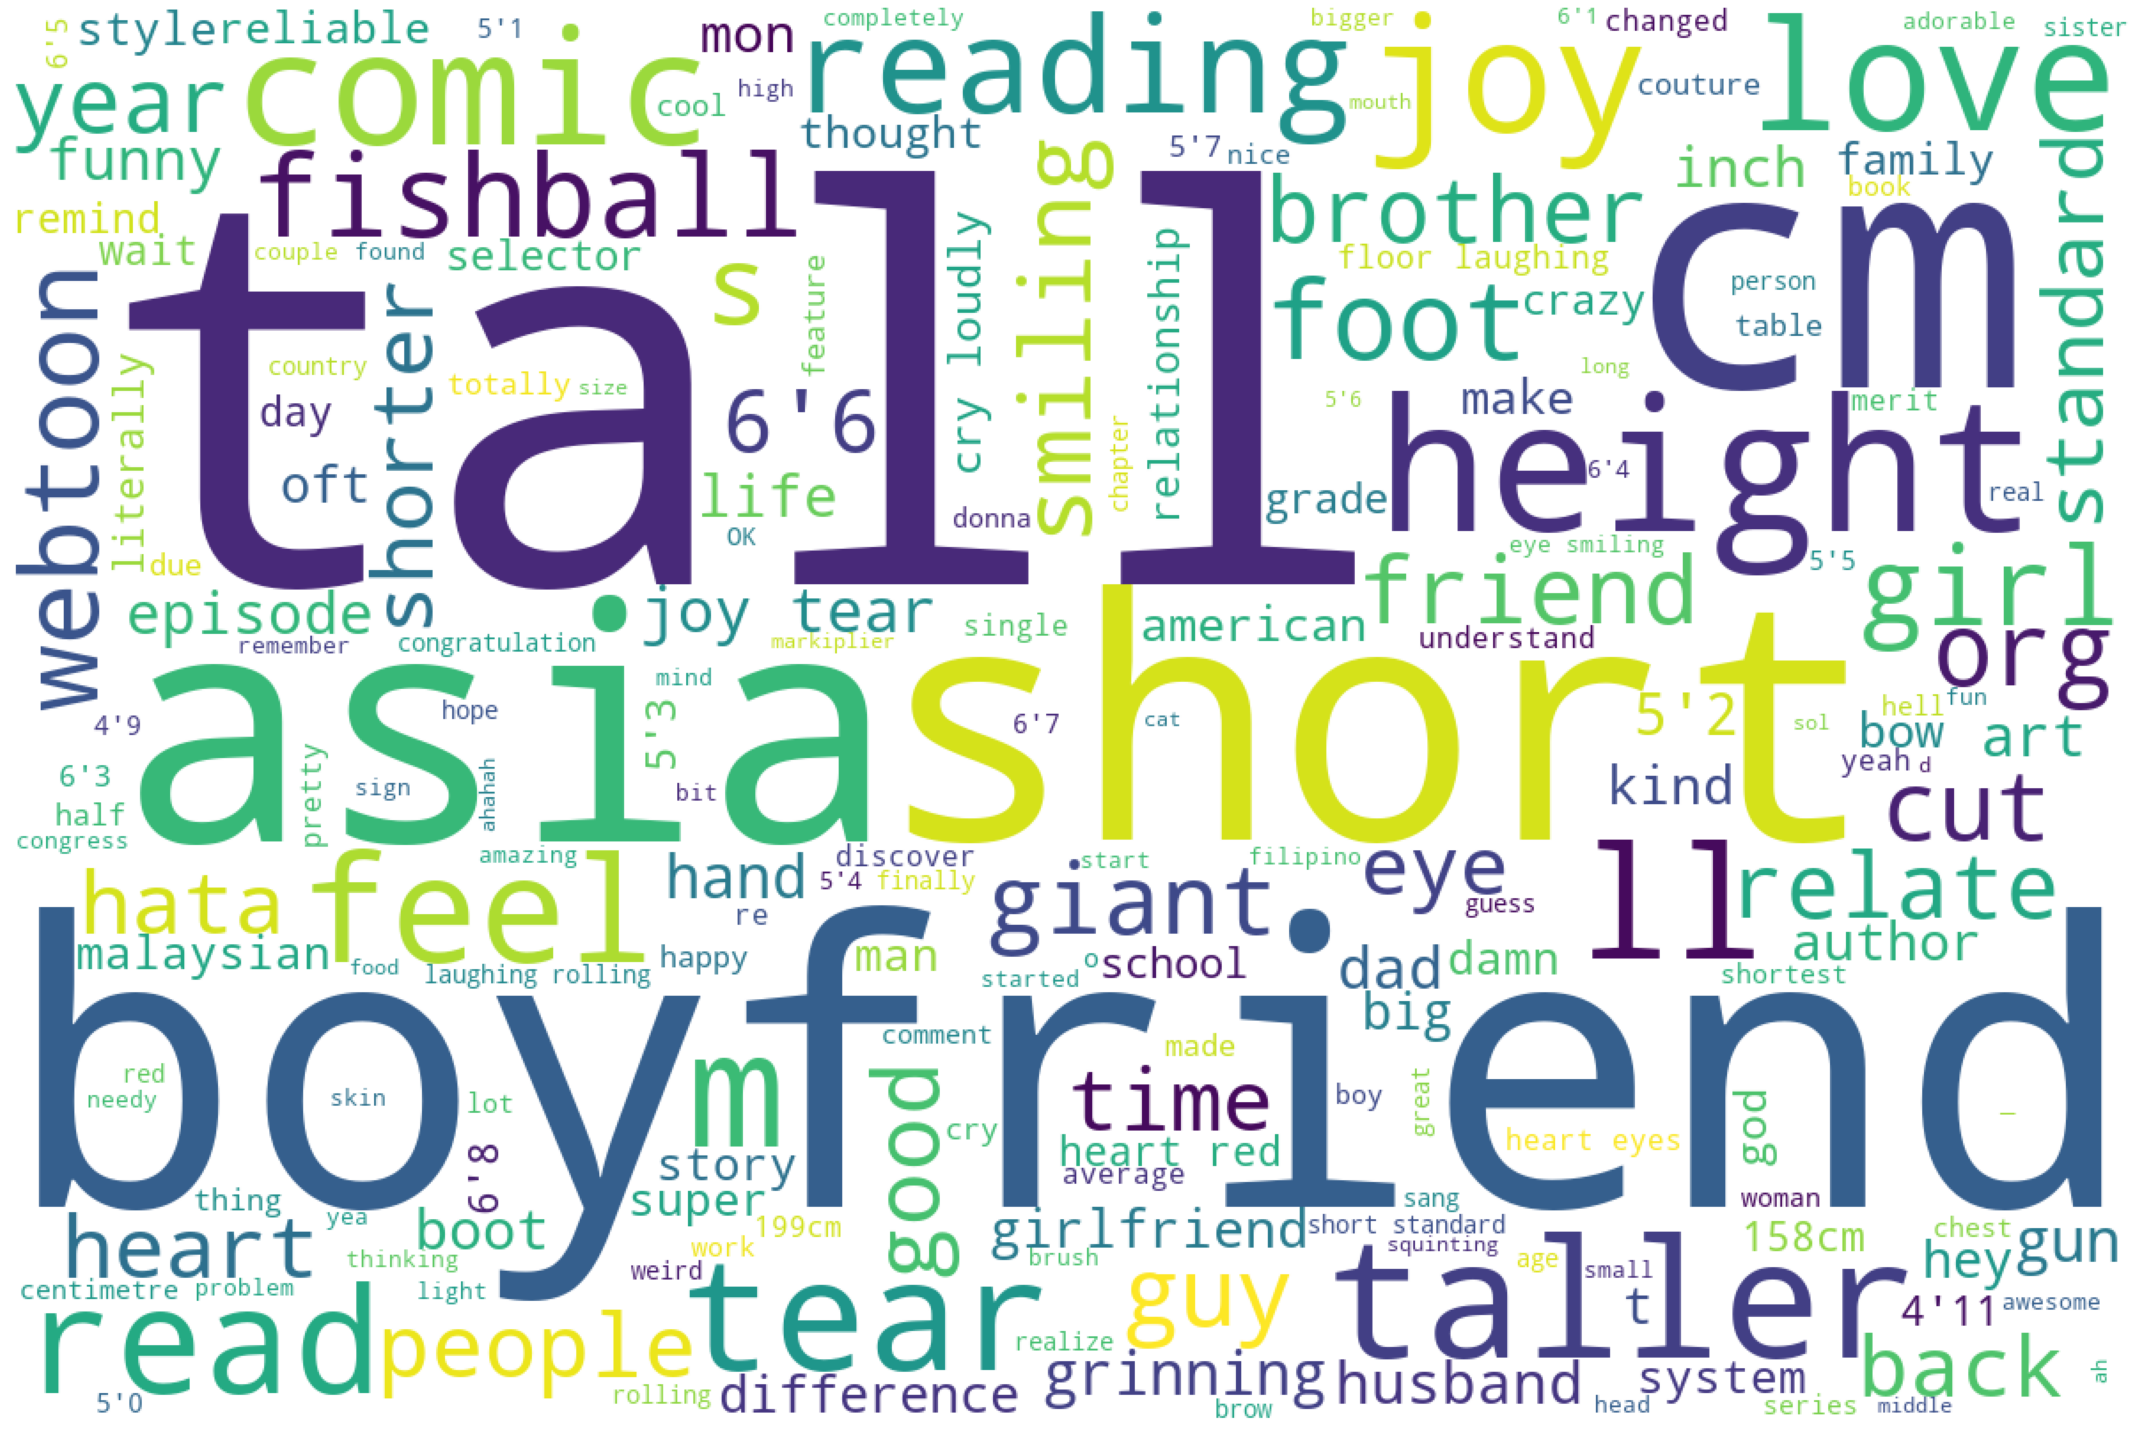

In [26]:
all_words = ''
for arg in comments['prep']:
    tokens = arg.split()
    all_words += ' '.join(tokens)+' '

# generate word cloud
wordcloud = WordCloud(width=1200, height=800,
                      background_color='white',
                      min_font_size=10
                     ).generate(all_words)

plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout()
plt.show()

## Conclusions

Based on the visual above we can see that the most commonly used words in the comments were "tall", "boyfriend", and "short. In general, the readers of _My Giant Nerd Boyfriend_ Episode 1 have agreed that the artist's boyfriend is indeed very tall and most readers that commented also have a boyfriend that is much taller than they are. Many readers have also stated they relate to the artist's height, saying that they, too, are short. One thing to note is that the artist is based in Malaysia. The word "asia" is another highly used word in the comments, which could indicate that many of the readers are also Asian and feel pride that an Asian artist is so popular on WEBTOON. Lastly, scattered throughout the visual are words like "joy", "funny", "heart", and "love", meaning that the audience generally had a positive reaction towards the story.

Overall, the comments show that Episode 1 of _My Giant Nerd Boyfriend_ is the beginning of a series that WEBTOON readers will find to be very relatable and put them in a good mood. 